<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Fitting" data-toc-modified-id="Model-Fitting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Fitting</a></span></li><li><span><a href="#Interpreting-Results" data-toc-modified-id="Interpreting-Results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interpreting Results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 



from IPython.display import display_html,display, Markdown


_Reading in data from csv's this is the same as the dataframes which exist at the end of the preprocessing stage_ <br>
_We can create the same <code>data</code> dataframe by simply concatenating the dem_df and lab_df from the preprocessing stage_

In [2]:
dem_df = pd.read_csv("Demographics.csv")
lab_df = pd.read_csv("Labour.csv")
data = pd.concat([dem_df,lab_df],axis=1)
data

,age,gender,race,highest_grade,tertiary_edu,province_current,province_moved,province_before,province_during,labour_in_feb,work_days_feb,work_hours_feb,take_home_pay_feb,labour_in_apr,work_days_apr,work_hours_apr,take_home_pay_apr,lost_labour,return_to_work,usual_work
0,39.0,Man,White,Grade 9,No,Gauteng,No,NaN,NaN,1,NaN,NaN,180.0,0,0.0,0.0,0.0,1,0,Unknown
1,72.0,Woman,Asian/Indian,Grade 0,NaN,KwaZulu-Natal,No,NaN,NaN,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed
2,30.0,Woman,African/Black,Grade 10,Yes,Gauteng,No,NaN,NaN,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed
3,48.0,Woman,African/Black,Grade 10,No,Gauteng,No,NaN,NaN,1,3.0,5.0,900.0,0,0.0,0.0,0.0,1,1,Elementary occupations
4,49.0,Woman,African/Black,Grade 9,No,Gauteng,No,NaN,NaN,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7068,22.0,Man,African/Black,Grade 11,No,Northern Cape,No,NaN,NaN,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed
7069,24.0,Woman,Coloured,Grade 10,No,Western Cape,No,NaN,NaN,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed
7070,36.0,Woman,African/Black,NTC 3,No,North West,No,NaN,NaN,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed
7071,20.0,Man,African/Black,Grade 12,No,North West,Yes,Gauteng,Gauteng,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,Not Employed


# Labour Model

## Model Fitting

In _The labour market and poverty impacts of COVID-19 in South Africa_ Jain _et al_. identified that "Women, manual workers and those at the bottom half of the income distribution" were at the greatest risk of losing their employment. Ranchhod and Daniels found in their paper _Labour market dynamics in the time of COVID-19_ that "Women, African/Blacks, youth and the less educated groups" were at the greatest disadvantage. We explore each of these contributing factors, to shed light on the effect they had on the loss of labour during the initial stages of COVID-19 in South Africa and determine which factors contributed the most to whether or not an individual would lose their job. The following features from the dataset will be used to represent each of these factors:
* **Youth:** We will experiment with models using age as both a continuous and a categorical feature. For statistical purposes the [United Nations](https://www.un.org/esa/socdev/documents/youth/fact-sheets/youth-definition.pdf) defines youth as any individual between the ages of 15-24. We have seen in our EDA that the youngest respondent is 18 years old, so our Youth variable will simply use the <code>age</code> feature and indicate if an individual is older than 24.


* **Woman:** To indicate whether or not a respondent is a woman, we will one-hot encode the <code>gender</code> feature.



* **Income:** In our EDA we identified that the income distribution contains several outliers. To remove these outliers for the modelling process we will drop the top 5% of earners from our data. We will use the <code>take_home_pay_feb</code> feature to capture a respondents income. This feature will also be scaled using minimum-maximum normalization to ensure it's coefficient in the regression model is in a similar scale with the other coefficients. 



* **Education:** In the EDA phase we discovered that the <code>highest_grade</code> variable contains both standard grades (Grade 1 - Grade 12) as well as other qualifications such as the NCV and the NTC. To incorporate this factor into our model we will create a new binary categorical feature, "Matric", which indicates whether or not a respondent's highest grade was Grade 12. We also incorporate the <code>tertiary_edu</code> feature to further represent a respondents education. As previously noted, this variable indicates whether the respondent has any tertiary qualifications such as diplomas, certificates or degrees.


* **African/Black:** This factor is incorporated by utilizing the <code>race</code> feature from the original dataset.


It is important to note that because our investigation pertains to the loss of labour, we will be using a subset of our original dataset consisting only of respondents who had some form of work, permanent or part-time, in the beginning of February 2020. These respondents can be selected using the <code>labour_in_feb</code> variable as outlined above. 

We make the assumption that if a respondent did not answer any of the questions relating to work, resulting in null values in the feature columns, that they were unemployed in the beginning of February 2020. We also assume that if a respondent did not answer the question concerning qualifications, that they do not have a tertiary education. 

In [3]:
# Selecting the respondents who had some form of work in the beginning of February 2020.
data = data[data["labour_in_feb"]==1]
data.shape

(3216, 20)

In [4]:


# Data transformations as outlined above. 
def check_age(age):
    if age<25: return 1
    else: return 0 

def check_gender(gender):
    if gender == "Woman": return 1
    else: return 0

def check_matric(highest_grade):
    if highest_grade == "Grade 12": return 1
    else: return 0

def check_tertedu(tertiary_edu):
    if tertiary_edu == "Yes" : return 1 
    else: return 0 
    
def check_race(race):
    if race == "African/Black": return 1
    else: return 0 

# Create dataframe using transformed varaibles 
model = pd.DataFrame()
model["Age"] = data["age"]
model["Youth"] = np.vectorize(check_age)(data["age"])
model["Woman"] = np.vectorize(check_gender)(data["gender"])
model["Income"] = data["take_home_pay_feb"]
model["Matric"] = model["Matric"] = np.vectorize(check_matric)(data["highest_grade"])
model["Tertiary_edu"] = np.vectorize(check_tertedu)(data["tertiary_edu"])
model["Black"] = np.vectorize(check_race)(data["race"])
model["LostLabour"] = data["lost_labour"]

# Remove missing values from the new dataframe 
model = model.dropna()

# Removing Income outliers
model = model[model["Income"]<np.percentile(a = model["Income"], q =95)]

# Normalize Income 
model["Income"] = model["Income"] = (model["Income"]-model["Income"].min())/ (model["Income"].max()-model["Income"].min())

display(model.head())
model.shape

,Age,Youth,Woman,Income,Matric,Tertiary_edu,Black,LostLabour
0,39.0,0,0,0.008654,0,0,0,1
3,48.0,0,1,0.043269,0,0,1,1
9,31.0,0,0,0.384615,0,0,1,1
10,48.0,0,1,0.221154,1,1,1,0
20,40.0,0,1,0.168269,0,0,1,0


(2372, 8)

In [5]:
model[model["LostLabour"]==0]

,Age,Youth,Woman,Income,Matric,Tertiary_edu,Black,LostLabour
10,48.0,0,1,0.221154,1,1,1,0
20,40.0,0,1,0.168269,0,0,1,0
28,43.0,0,1,0.021635,1,0,1,0
31,56.0,0,1,0.091346,0,0,1,0
36,46.0,0,0,0.019231,0,0,1,0
...,...,...,...,...,...,...,...,...
7021,27.0,0,1,0.072115,0,0,1,0
7032,44.0,0,1,0.192308,0,0,1,0
7038,25.0,0,1,0.261058,1,1,1,0
7043,43.0,0,0,0.307692,0,0,1,0


First we will split the data into a training set, which will be used to select a final model and a test set, which will be used to evaluate the final model. The train-test split we use is a 70%-30% split, respectively. We will utilize the <code>stratify</code> command to ensure the train and test data both have similar distributions of the response variable categories.

In [6]:
# Splitting the data into the explanatory varaibles X and the response variable y 
X = model.drop("LostLabour", axis=1)
y = model["LostLabour"]

# Split the data into a 70% training set and a 30% testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify= y)

# Create the model_train and model_test data by concatenating the X and y variables. 
model_train = pd.concat([X_train, y_train], axis =1)
model_test = pd.concat([X_test, y_test], axis =1)


model_train

,Age,Youth,Woman,Income,Matric,Tertiary_edu,Black,LostLabour
4563,40.0,0,0,0.240385,1,0,1,1
3711,25.0,0,0,0.144231,0,0,1,0
3615,22.0,1,1,0.067308,0,1,1,1
666,27.0,0,0,0.057692,0,0,1,0
6206,29.0,0,0,0.036058,0,0,1,1
...,...,...,...,...,...,...,...,...
2835,45.0,0,0,0.336538,1,0,0,0
2131,31.0,0,0,0.201923,0,0,1,0
6501,43.0,0,0,0.216346,0,0,1,1
700,31.0,0,1,0.182692,1,0,1,0


Due to the fact that we are using the Youth, Woman, Income, Matric, Tertiary Education and Black response variables to model a categorical response variable (LostLabour) with only two response categories, we will be constructing a Binary Logistic Regression. 

The initial model will be constructed using all of the features that are identified in the literature as being the greatest contributing factors, this will allow us to ascertain the validity of these conclusion and determine which features are indeed statistically significant. The initial model has the formula: 

$$y = \beta_0 + \beta_1youth + \beta_2woman + \beta_3income + \beta_4matric + \beta_5tertiary\_edu + \beta_6black$$

Where $y$ represents the logarithm of the odds that a respondent will lose their labour: $y = log(\frac{p}{1-p})$, $p$ is the probability of an individual losing their job. 

Constructing this initial model using the training data yields:

In [7]:
fitlogreg = smf.logit(formula = 'LostLabour ~ Youth + Woman + Income + Matric + Tertiary_edu + Black ', data = model_train).fit(disp=0)
fitlogreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             LostLabour   No. Observations:                 1660
Model:                          Logit   Df Residuals:                     1653
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.03707
Time:                        23:40:03   Log-Likelihood:                -1104.5
converged:                       True   LL-Null:                       -1147.0
Covariance Type:            nonrobust   LLR p-value:                 3.256e-16
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1331      0.158     -0.843      0.399      -0.443       0.176
Youth            0.0036      0.188      0.019      0.985      -0.365       0.372
Woman            0.4282      0.104      4.122      0.000       0.225       0.632
Income          -1.5955      0.282     -5.657      0.000      -2.148      -1.043
Matric           0.1382      0.114      1.215      0.225      -0.085       0.361
Tertiary_edu    -0.1259      0.125     -1.011      0.312      -0.370       0.118
Black            0.3814      0.134      2.845      0.004       0.119       0.644
================================================================================
"""

Inspecting the results of this initial implementation we observe that some features have a considerably lower p-value than others, suggesting that these could be statistically more significant. We can select a subset of features and construct a reduced model as: 

$$y = \beta_0 +  \beta_1income + \beta_2woman  + \beta_3black$$

The reduced model yields the following results: 

In [8]:
fitlogreg = smf.logit(formula = 'LostLabour ~ Income + Woman + Black ', data = model_train).fit(disp=0)
fitlogreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             LostLabour   No. Observations:                 1660
Model:                          Logit   Df Residuals:                     1656
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.03622
Time:                        23:40:03   Log-Likelihood:                -1105.4
converged:                       True   LL-Null:                       -1147.0
Covariance Type:            nonrobust   LLR p-value:                 6.668e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1106      0.152     -0.728      0.466      -0.408       0.187
Income        -1.5813      0.254     -6.238      0.000      -2.078      -1.084
Woman          0.4184      0.102      4.096      0.000       0.218       0.619
Black          0.3943      0.133      2.958      0.003       0.133       0.656
==============================================================================
"""

Performing sensibility checks on the coefficients acquired by both of these models we can see that the regression coefficient for the <code>Woman</code> feature is positive in both cases, this indicates that a respondent being a woman _increases_ the probability that they would lose their job, the same can be said about the regression coefficient for the <code>Black</code> feature. These findings agree with what has been indicated in the literature. 

On the other hand, the regression coefficient for the <code>Income</code> feature is negative. Once again this agrees with our expectations as a _higher_ income , according to the literature, should results in a _lower_ probability of an individual losing their job.

The <code>Income</code> feature has the biggest coefficient, indicating that it could be the most influential of the three feautres, let us see if we can reduce this model even further to a simple Logistic Regression with <code>Income</code> as our only explanatory variable. 

In [9]:
fitlogreg = smf.logit(formula = 'LostLabour ~ Income', data = model_train).fit(disp=0)
fitlogreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             LostLabour   No. Observations:                 1660
Model:                          Logit   Df Residuals:                     1658
Method:                           MLE   Df Model:                            1
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.02555
Time:                        23:40:03   Log-Likelihood:                -1117.7
converged:                       True   LL-Null:                       -1147.0
Covariance Type:            nonrobust   LLR p-value:                 1.918e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4915      0.069      7.124      0.000       0.356       0.627
Income        -1.8279      0.249     -7.344      0.000      -2.316      -1.340
==============================================================================
"""

To decide on a final model , we will conduct hypothesis testing to examine the difference in explanatory power of the last two models. This will allows us to determine whether including the additional variables, <code> Woman </code> and <code> Black </code>, is useful or not. To conduct this test we will utilize the Likelihood Ratio Test. Using the full model of 
$$y = \beta_0 +  \beta_1income + \beta_2woman  + \beta_3black$$

Our null hypothesis can be stated as:
$$H_0: \beta_2 = \beta_3 = 0$$
And our model under the null hypothesis as:
$$y_0 = \beta_0 +  \beta_1income $$

Our alternative hypothesis is therefore: 
$$H_a: \beta_2 \neq 0, \beta_3 \neq 0$$

Resulting in the full model being the model under the alternative hypothesis or:

$$y_a = \beta_0 +  \beta_1income + \beta_2woman  + \beta_3black$$

To conduct the hypothesis test we will utilize a bootstrapping procedure in which we resample from our data with replacement and calculate the Log Likelihood Ratio test statistic at each iteration, this is be done 5000 times to create a distribution of the test statistic. From this distribution we can determine our p_value and whether or not to reject our null hypothesis. We will use a 95% significance level for the hypothesis testing procedure.

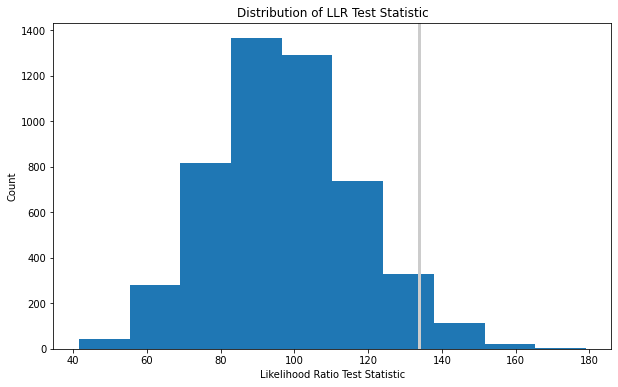

p-value: 0.0418


In [10]:
# Create the model and calculate the actual test statistic for the data 
fitlogreg = smf.logit(formula = 'LostLabour ~ Woman + Income + Black  ', data = model).fit(disp=0)

# The Log Likelihood Ratio can be accessed using llr in the statsmodels package 
actual_test_stat  = fitlogreg.llr

# A list to store the test statistic for each iteration 
test_stats = [] 

for i in range(5000):
    # Create a bootstrapped sample 
    bstrp_sample = model.sample(frac=1, replace=True)
    # Fit the model using this bootstrapped sample 
    fitlogreg = smf.logit(formula = 'LostLabour ~ Income ', data = bstrp_sample).fit(disp=0)
    # Store the test statistic for this iteration 
    test_stats.append(fitlogreg.llr)
    
# Plot a graph of the test statistics distribution
plt.figure(figsize=(10,6))
plt.axvline(actual_test_stat, linewidth=3, color='0.8')
plt.hist(test_stats)
plt.title("Distribution of LLR Test Statistic")
plt.xlabel('Likelihood Ratio Test Statistic')
plt.ylabel('Count')
plt.show()

# Calculate and display the p-value
pvalue = sum(test_stats >= actual_test_stat) / len(test_stats)
print("p-value:", pvalue)

The p-value is less than 0.05 which is what we need in order to reject the null hypothesis at our current significance level. Therefore we cannot reject our null hypothesis. We can see that the inclusion of the <code>Woman</code> and <code>Black</code> features is definitely useful and can therefore select our final model as: 

$$y_a = \beta_0 +  \beta_1income + \beta_2woman  + \beta_3black$$

Before evaluating it on the test set, let us analyze the residuals of this model to ensure there are no major issues evident. 

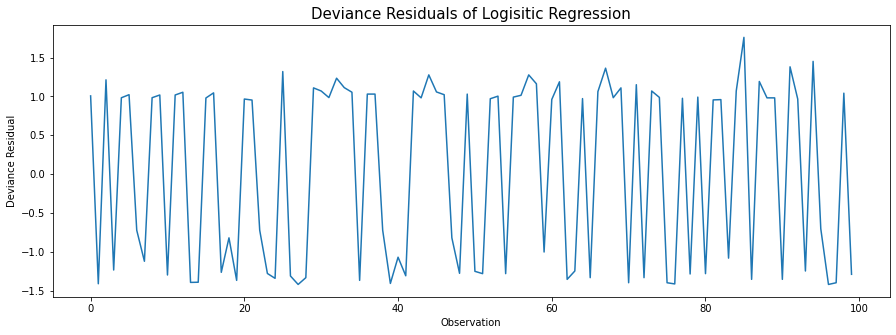

In [11]:
plt.figure(figsize=(15,5))
plots = fitlogreg.resid_dev[:100]
plt.plot(range(100), plots.values)
plt.title("Deviance Residuals of Logisitic Regression", fontsize=15)
plt.ylabel("Deviance Residual")
plt.xlabel("Observation")
plt.show()

Observing that there are no apparent patterns in the residual plot allows us to conclude that there are no major issues with the fitted model. We can now evaluate the model using the test data. 

In [12]:
fitlogreg = smf.logit(formula = 'LostLabour ~ Woman + Income + Black ', data = model_test).fit(disp=0)
display(fitlogreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             LostLabour   No. Observations:                  712
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Jun 2021   Pseudo R-squ.:                 0.05656
Time:                        23:41:43   Log-Likelihood:                -464.08
converged:                       True   LL-Null:                       -491.90
Covariance Type:            nonrobust   LLR p-value:                 5.011e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3263      0.255     -1.278      0.201      -0.827       0.174
Woman          0.2753      0.160      1.720      0.085      -0.038       0.589
Income        -2.1525      0.421     -5.115      0.000      -2.977      -1.328
Black          0.8266      0.231      3.582      0.000       0.374       1.279
==============================================================================
"""

## Interpreting Results
* All relevant metrics considered (3) 
* Correctness of interpretation (3) 
* Did results meet expectations? Why? (4)
* Considerations of impact of 
    * Quality of Data
    * Assumptions 
    * Testing Methodology

## Conclusion 